new pomcp from scratch!

In [2]:
# new pomcp from scratch

In [2]:
# imports
from random import randint
import numpy as np
import random
import datetime # for limiting calculation to wall clock time
import math
import copy
import matplotlib.pyplot as plt


In [3]:
# # game class
class TigerProblem():
    def __init__(self,obs_truth = 0.8):
#         self.state = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
        self.obs_truth = obs_truth # how much you can trust observations
        self.all_states = set(['tiger-left','tiger-right'])
        
    # this contains the transition function for the MDP
    def next_state(self, state, action):
        
        assert action in ['listen','open-left','open-right'], "invalid action"
        
        if action == 'listen':
            return state
        elif action == 'open-left':
            return ('tiger-left' if random.random() < 0.5 else 'tiger-right')
        elif action == 'open-right':            
            return ('tiger-left' if random.random() < 0.5 else 'tiger-right')
       
    # observation function for the POMDP
    def observation(self, state, action):  
        
        assert action in ['listen','open-left','open-right'], "invalid action"
        
        all_s = self.all_states
        
        if action == 'listen':
            if random.random() < self.obs_truth:
                return state
            else:
                other = [st for st in self.all_states if st != state]
                return other[0]
        else:
#             return []
            if random.random() < 0.5:
                return state
            else:
                other = [st for st in self.all_states if st != state]
                return other[0]
        
    # Take a sequence of game states representing the full game tree, and return the full list
    # of actions that are legal actions
    def legal_actions(self,state_hist): 
        return ['listen','open-left','open-right']
    
    # Should this be the length of state_tree (how long tama alive for)? or is it trial by trial rwd?
    def reward(self, state, action):
        if action == 'listen':
            return -1
        elif action == 'open-left':
            return -20 if state == 'tiger-left' else 10
        elif action == 'open-right':            
            return -20 if state == 'tiger-right' else 10
            
    # GENERATOR MODEL OF GAME
    # returns next state, observation, and reward given an action taken in given state
    # takes tuple state
    def G_model(self,state,action):
        s = self.next_state(state,action)
        obs = self.observation(state,action)
        rwd = self.reward(state,action) # note that this should be more like immediate reward of state, not long-term?
        done = False
        return s, obs, rwd, done
    
    # Initial state distribution
    # Initial state distribution
    def sample_prior(self):
        s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
        return s
    
    # when filtering particles, this is the rule to keep one given a real observation
    def keep_particle(self, part, real_obs):
        trash_prob = 0.8
        if real_obs == []:
            return True
        if part != real_obs and random.random() < trash_prob:
            return False
        return True

    #     if real_obs == []:
    #         return True
    #     else:
    #         if part == real_obs:
    #             return True
    #     return False

    # generate a new particle from one randomly sampled from current belief (e.g., just add a lil noise)
    def new_particle(self, part):
        s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
        return s

In [4]:
class SearchTree(object):
    def __init__(self,visits=1,value=0):
        self.visits = visits
        self.value = value
        self.children=[]
        
        
class ActionNode(SearchTree):
    def __init__(self,action=None,visits=1,value=0):
        super().__init__(visits,value)
        self.action = action
        
        
class ObservationNode(SearchTree):
    def __init__(self,observation=[],visits=1,value=0,belief=[]):
        super().__init__(visits,value)
        self.observation = observation
        self.belief = belief
        
    def expand(self, legal_actions):
        for a in legal_actions:
            self.children += [ActionNode(a)]
            
        # upper confidence bound value for given node "child"
    def ucb(self, child): #maybe use index of child not object
#         print("self.visit=",self.visit," len of self.children=",len(self.children))
        logval = math.log(self.visits) #, len(self.children))
        div = logval / child.visits
        return math.sqrt(div)
    
#     def sample_belief(self):
#         return random.choice(self.belief)
    
    def next_hist(self,action,obs):
        act_child = next((c for c in self.children if c.action==action), None)
        assert act_child != None, "shouldn't you be expanded already?"
        assert isinstance(act_child, ActionNode), "action child should be an action node!"
        
        obs_child = next((c for c in act_child.children if c.observation == obs), None) 
        if obs_child is None:
            act_child.children += [ObservationNode(obs)]
#             print(act_child.children[0].observation)
            obs_child = next((c for c in act_child.children if c.observation == obs), None)     
        return obs_child
    
#     def next_hist_rollout(self,action,obs):
        

In [5]:
class POMCP:
    def __init__(self, 
                 game=TigerProblem(),
                 discount=0.8,
                 explore=1,
                 epsilon=1e-7,
                 n_particles=100,
                 reinvigoration=20, 
                 **kwargs):
        
#         self.context = {}
        self.game = game
        self.discount = discount
        self.epsilon = epsilon
        self.explore = explore
        self.n_particles = n_particles
        self.reinvigoration = reinvigoration
        self.G = game.G_model      
        self.tree = None
        self.history = []
        # list of all possible actions
#         self.actions = kwargs.get('actions') 
        
        seconds = kwargs.get('time',30)
        self.calculation_time = datetime.timedelta(seconds=seconds)
        self.maxdepth = kwargs.get('maxdepth',20)
        self.nsims = kwargs.get('nsims',1000)
        
    def search(self,obs):
        
        self.history += [obs]
        
        if self.tree is None:
            self.tree = ObservationNode(obs)                        
#             particle = self.game.sample_prior()
#             self.simulate(particle,self.tree,0)
        else:
            self.prune_tree(obs)
            
        for _ in range(self.nsims):
            particle = self.draw_sample()
            self.simulate(particle,self.tree,0)
        
        child = self.greedy_action_selection(self.tree,self.game.legal_actions(self.tree)) # will again need to handle legal actions differently for real
        self.tree = child # move forward to child action node (will move to obs node when real obs occurs)
        self.history += [child.action]
        
        return child.action
    
    def simulate(self,state,tree,depth):
        if depth >= self.maxdepth:
            return 0
        
#         legal = self.game.legal_actions(state,tree,depth)
        legal = self.game.legal_actions(tree) # would want it to be more elegant/complicated for real
    
        if len(tree.children) == 0:
            tree.expand(legal)
            return self.rollout(state,depth)
        
        if len(legal)==1:
            action = legal[0]
            child = tree.children[0]
        else:
            child = self.ucb_action_selection(tree,legal)
            action = child.action
            
        next_state, next_obs, r, done = self.G(state,action)
        next_tree = tree.next_hist(action,next_obs)
        reward = r + self.discount * self.simulate(next_state,next_tree,depth+1)
        
        tree.belief += [state] 
        tree.visits += 1
        
        child.visits += 1
        child.value += (reward - child.value)/child.visits
        
        return reward
    
    def rollout(self,state,depth):
        if depth >= self.maxdepth:
            return 0
        
        legal = self.game.legal_actions(["whatever but change this later"])
        a = random.choice(legal)
        
        next_state, next_obs, r, done = self.G(state,a)
#         next_tree = tree.next_hist(a,next_obs)
        
        if done:
            return r
        
        return r + self.discount * self.rollout(next_state,depth+1)
        
    def prune_tree(self,obs):
        #current tree is an action node. find child node with observation obs
        obs_child = next((c for c in self.tree.children if c.observation == obs), None) 
        self.tree = obs_child
        return
        
    def greedy_action_selection(self,tree,legal):
        children = [child for child in tree.children if child.action in legal] #filter(lambda child: child.action in legal_actions, tree.children)
        child_vals = np.array([child.value for child in children])
        favechildren = np.argwhere(child_vals == np.amax(child_vals))
        child = children[random.choice(favechildren.flatten().tolist())]
        return child
        
    def ucb_action_selection(self,tree,legal):
        children = [child for child in tree.children if child.action in legal] #filter(lambda child: child.action in legal_actions, tree.children)
        child_vals = np.array([child.value + self.explore * tree.ucb(child) for child in children])
        favechildren = np.argwhere(child_vals == np.amax(child_vals))
        child = children[random.choice(favechildren.flatten().tolist())]
        return child
    
    def draw_sample(self):
        if self.tree.belief == []:
            return self.game.sample_prior()
        else:
            return random.choice(self.tree.belief)

In [40]:
s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
game = TigerProblem()
agent = POMCP(game, 0.9, maxdepth=20, nsims=1000)

In [7]:
# Check that the tree runs simulations to choose the next action using the choose_move() method

print("INITIAL STATE: ")
print(s) # initial tiger problem state

obs = []

action = agent.search(obs)
print("Taking action:", action)
state = game.next_state(s,action)
game.reward(s,action)

INITIAL STATE: 
tiger-right
Taking action: listen


-1

In [8]:
# if next obs is tiger-left,
observeright = 1 #1 if observes right on next observation, 0 if observes left
nparticles = len(agent.tree.children[observeright].belief)
nleftbelief = len([b for b in agent.tree.children[observeright].belief if b=='tiger-left'])
nrightbelief = len([b for b in agent.tree.children[observeright].belief if b=='tiger-right'])
print(['left belief:',nleftbelief])
print(['right belief:',nrightbelief])
print(['left belief percentage:',nleftbelief/nparticles])

['left belief:', 4290]
['right belief:', 3942]
['left belief percentage:', 0.5211370262390671]


In [9]:
# so clearly i still need to limit how many particles are added to each observation node but also like, 
# this doesn't seem right, the beliefs should be different given the real observation that happens next
# ALSO, when there are many many many more possible actions i might not really need to limit it that much


In [10]:
# Now, let the POMCP do its thing for several actions in a row

# Initialize the tiger problem
s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
game = TigerProblem(1.0) #obs_truth=0.95)
    
print("INITIAL STATE: ")
print(s) # initial tiger state

agent = POMCP(game, 0.9, maxdepth=20, nsims=1000)

action_seq = []
state = s
obs = []
R = 0


while len(action_seq) <= 20: # play for a certain amount of time (better rule?)

    action = agent.search(obs)
    action_seq.append(action)
    print('Action %i: True state is %s'% (len(action_seq), state))
    print("Taking action %s."% action)
    
    obs = game.observation(state,action)
    if obs!=[]:
        print("observed ",obs)

    r = game.reward(state,action)
    R = R + r
    print("Reward so far: ",R)    
    
    state = game.next_state(state,action)
    

    
print("game over!")

INITIAL STATE: 
tiger-right
Action 1: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  -1
Action 2: True state is tiger-right
Taking action open-left.
Reward so far:  9
Action 3: True state is tiger-right
Taking action open-left.
Reward so far:  19
Action 4: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  18
Action 5: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  17
Action 6: True state is tiger-left
Taking action open-right.
Reward so far:  27
Action 7: True state is tiger-left
Taking action open-left.
Reward so far:  7
Action 8: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  6
Action 9: True state is tiger-right
Taking action open-left.
Reward so far:  16
Action 10: True state is tiger-left
Taking action open-left.
Reward so far:  -4
Action 11: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -5
Action

In [11]:
# now let's compare the performance of different exploration coeff C

storeobservations = []
storeactions = []
storerewards = []
cs = [0,1,1.4,2,2.5,3,4,5,10,50]

for c in cs:
    print("C = ", c)
    # Initialize the tiger
    s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
    game = TigerProblem(1.0) #obs_truth=0.95)

    print("INITIAL STATE: ")
    print(s) # initial tiger state

    agent = POMCP(game, 0.9, c, maxdepth=20, nsims=1000)

    action_seq = []
    obs_seq = []
    state = s
    obs = []
    R = 0


    while len(action_seq) <= 20: # play for a certain amount of time (better rule?)

        action = agent.search(obs)
        action_seq.append(action)
        print('Action %i: True state is %s'% (len(action_seq), state))
        print("Taking action %s."% action)

        obs = game.observation(state,action)
        obs_seq.append(obs)
        
        if obs!=[]:
            print("observed ",obs)

        r = game.reward(state,action)
        R = R + r
        print("Reward so far: ",R)    

        state = game.next_state(state,action)

    print("game over!")
    storeobservations.append([obs_seq])
    storeactions.append([action_seq])
    storerewards.append(R)

C =  0
INITIAL STATE: 
tiger-left
Action 1: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -1
Action 2: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -2
Action 3: True state is tiger-left
Taking action open-right.
Reward so far:  8
Action 4: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  7
Action 5: True state is tiger-left
Taking action open-right.
Reward so far:  17
Action 6: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  16
Action 7: True state is tiger-right
Taking action open-left.
Reward so far:  26
Action 8: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  25
Action 9: True state is tiger-right
Taking action open-left.
Reward so far:  35
Action 10: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  34
Action 11: True state is tiger-right
Taking action listen.


Reward so far:  27
Action 7: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  26
Action 8: True state is tiger-right
Taking action open-left.
Reward so far:  36
Action 9: True state is tiger-left
Taking action open-left.
Reward so far:  16
Action 10: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  15
Action 11: True state is tiger-right
Taking action open-left.
Reward so far:  25
Action 12: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  24
Action 13: True state is tiger-right
Taking action open-left.
Reward so far:  34
Action 14: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  33
Action 15: True state is tiger-left
Taking action open-right.
Reward so far:  43
Action 16: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  42
Action 17: True state is tiger-left
Taking action listen.
observed  tiger-left
Rewar

Action 13: True state is tiger-left
Taking action open-left.
Reward so far:  45
Action 14: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  44
Action 15: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  43
Action 16: True state is tiger-left
Taking action open-right.
Reward so far:  53
Action 17: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  52
Action 18: True state is tiger-right
Taking action open-left.
Reward so far:  62
Action 19: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  61
Action 20: True state is tiger-left
Taking action open-right.
Reward so far:  71
Action 21: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  70
game over!
C =  50
INITIAL STATE: 
tiger-left
Action 1: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -1
Action 2: True state is tiger-left
Takin

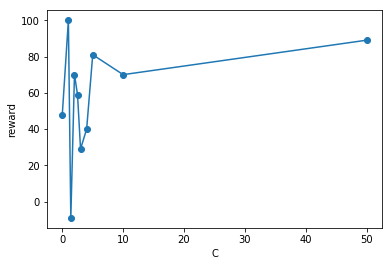

In [12]:
cashmoney = storerewards #[i for (i,a) in storerewards]
plt.plot(cs,cashmoney,'o-')
plt.xlabel("C")
plt.ylabel("reward")
plt.show()


In [13]:
print(cs)
storerewards

[0, 1, 1.4, 2, 2.5, 3, 4, 5, 10, 50]


[48, 100, -9, 70, 59, 29, 40, 81, 70, 89]

In [7]:
# now let's compare the performance of different nsims n

# storeobservations = []
# storeactions = []
# storerewards = []
ns = [100, 500, 1000, 2500, 5000, 6000, 7000, 8000, 9000, 10000]
c = 1

allobs, allacts, allrewards = [], [], []
nreps = [100,100,100,100,10,10,10,10,10,10]

for i in range(len(ns)):
    n = ns[i]
    print("nsims = ", n)
    storeobservations, storeactions, storerewards = [], [], []
    
    for rep in range(nreps[i]):
        print("rep ",rep)
        if 'game' in locals():
            del game
        if 'agent' in locals():
            del agent
        # Initialize the tiger
        s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
        game = TigerProblem(0.85) #obs_truth=0.95)

#         print("INITIAL STATE: ")
#         print(s) # initial tiger state

        agent = POMCP(game, 0.9, c, maxdepth=20, nsims=n)

        action_seq = []
        obs_seq = []
        state = s
        obs = []
        R = 0


        while len(action_seq) <= 20: # play for a certain amount of time (better rule?)

            action = agent.search(obs)
            action_seq.append(action)
#             print('Action %i: True state is %s'% (len(action_seq), state))
#             print("Taking action %s."% action)

            obs = game.observation(state,action)
            obs_seq.append(obs)

#             if obs!=[]:
#                 print("observed ",obs)

            r = game.reward(state,action)
            R = R + r
#             print("Reward so far: ",R)    

            state = game.next_state(state,action)

        
        storeobservations.append([obs_seq])
        storeactions.append([action_seq])
        storerewards.append(R)
        print("game over! reward ",R)
        
    allobs.append([storeobservations])
    allacts.append([storeactions])
    allrewards.append([storerewards])

nsims =  100
rep  0
game over! reward  37
rep  1
game over! reward  -1
rep  2
game over! reward  -20
rep  3
game over! reward  18
rep  4
game over! reward  -72
rep  5
game over! reward  29
rep  6
game over! reward  -12
rep  7
game over! reward  15
rep  8
game over! reward  29
rep  9
game over! reward  48
rep  10
game over! reward  -31
rep  11
game over! reward  34
rep  12
game over! reward  59
rep  13
game over! reward  -20
rep  14
game over! reward  -1
rep  15
game over! reward  78
rep  16
game over! reward  -20
rep  17
game over! reward  -42
rep  18
game over! reward  -39
rep  19
game over! reward  -4
rep  20
game over! reward  -31
rep  21
game over! reward  -34
rep  22
game over! reward  -39
rep  23
game over! reward  -20
rep  24
game over! reward  -9
rep  25
game over! reward  29
rep  26
game over! reward  10
rep  27
game over! reward  18
rep  28
game over! reward  48
rep  29
game over! reward  -23
rep  30
game over! reward  -1
rep  31
game over! reward  37
rep  32
game over! rewar

game over! reward  -1
rep  71
game over! reward  29
rep  72
game over! reward  -31
rep  73
game over! reward  -1
rep  74
game over! reward  -39
rep  75
game over! reward  37
rep  76
game over! reward  111
rep  77
game over! reward  59
rep  78
game over! reward  48
rep  79
game over! reward  51
rep  80
game over! reward  51
rep  81
game over! reward  7
rep  82
game over! reward  70
rep  83
game over! reward  -1
rep  84
game over! reward  -1
rep  85
game over! reward  -12
rep  86
game over! reward  -20
rep  87
game over! reward  40
rep  88
game over! reward  -4
rep  89
game over! reward  51
rep  90
game over! reward  -20
rep  91
game over! reward  -9
rep  92
game over! reward  29
rep  93
game over! reward  48
rep  94
game over! reward  18
rep  95
game over! reward  59
rep  96
game over! reward  29
rep  97
game over! reward  29
rep  98
game over! reward  78
rep  99
game over! reward  40
nsims =  2500
rep  0
game over! reward  59
rep  1
game over! reward  59
rep  2
game over! reward  89
re

In [48]:
print(ns)
print(nreps)
# print(allrewards)
rwds = np.array(allrewards)
print(len(ns))
meanrwds = np.zeros([len(ns),1])
print(np.shape(meanrwds))
print(np.array(rwds[3,0]))
for x in range(len(rwds)):
    meanrwds[x] = np.mean(np.array(rwds[x,0]))
print(meanrwds)

formattedrwds = np.array([np.array(rwds[0,0]),np.array(rwds[1,0]),np.array(rwds[2,0]),np.array(rwds[3,0]),np.array(rwds[4,0]),np.array(rwds[5,0]),np.array(rwds[6,0]),np.array(rwds[7,0]),np.array(rwds[8,0]),np.array(rwds[9,0])])
                          
# print(formattedrwds)                  

[100, 500, 1000, 2500, 5000, 6000, 7000, 8000, 9000, 10000]
1000
10
(10, 1)
[ 59  59  89  26  21  29  89  -1  78   7  59  59  78  -1 -58  29  29  -1
  51 -39  37  48  59  70  29  56  59  78  29 -23  29 -61  21  89   7  -4
  26 -31  10  29 -20  29  10  10 -47  48  40 -91 -58  10  29 -61  59  67
  37  51 -39  29  37  48  21  48  40  37 -20 -61  18 -12  10  21  18  18
 100  29  89 -20 -39 -20  -1  70 -50  78  40 -61   7  10 -20  -1   7  89
  37 -83  89  45  21 -20 -47   7  10  37]
[[ 7.95]
 [ 9.65]
 [16.9 ]
 [19.48]
 [ 7.7 ]
 [ 0.4 ]
 [-6.2 ]
 [35.5 ]
 [ 9.4 ]
 [28.2 ]]


[ 3.3106004   3.82097828  4.02873429  4.26857072 13.90039568 12.56359821
 13.23162877 14.05507026  8.81271808  5.95281446]


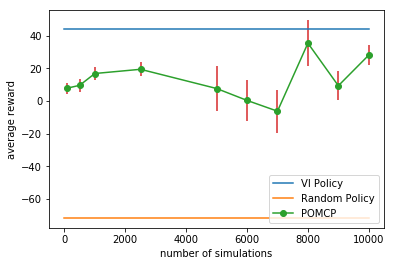

In [78]:
nreps = [100,100,100,100,10,10,10,10,10,10]
cashmoney = meanrwds #np.mean(rwds,axis=2) 
cashmoney_ste = np.zeros([len(ns),1])
for x in range(len(rwds)):
    cashmoney_ste[x] = np.std(np.array(rwds[x,0]))/np.sqrt(nreps[x])
# cashmoney_ste = np.std(allrewards,axis=2)/np.sqrt(nreps)
bars = cashmoney_ste.reshape([len(ns),1])[:,0]
print(bars)
# plt.plot([0,10000],[47.34,47.34],'-')
plt.plot([0,10000],[44.04,44.04],'-')
plt.plot([0,10000],[-71.643,-71.643],'-')
plt.plot(ns,cashmoney,'o-')
plt.errorbar(ns,cashmoney,yerr=bars,xerr=None,fmt='none')
plt.xlabel("number of simulations")
plt.ylabel("average reward")
plt.legend(['VI Policy','Random Policy', 'POMCP'],loc='lower right')
plt.show()


In [71]:
plt.hist(allrewards[1])
plt.show()

In [20]:
# Initialize the tiger problem
if game:
    del game
    del agent

s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
game = TigerProblem(.8) #obs_truth=0.95)
c = 1 #180
    
print("INITIAL STATE: ")
print(s) # initial tiger state

agent = POMCP(game, 0.9, c, maxdepth=21, nsims=10000)

action_seq = []
state = s
obs = []
R = 0

horizon = 10


while len(action_seq) < horizon: # play for a certain amount of time (better rule?)

    action = agent.search(obs)
    action_seq.append(action)
    print('Action %i: True state is %s'% (len(action_seq), state))
    print("Taking action %s."% action)
    
    obs = game.observation(state,action)
    if obs!=[]:
        print("observed ",obs)

    r = game.reward(state,action)
    R = R + r
    print("Reward so far: ",R)    
    
    state = game.next_state(state,action)
    

    
print("game over!")

INITIAL STATE: 
tiger-left
Action 1: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -1
Action 2: True state is tiger-left
Taking action open-right.
Reward so far:  9
Action 3: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  8
Action 4: True state is tiger-left
Taking action open-right.
Reward so far:  18
Action 5: True state is tiger-left
Taking action open-right.
Reward so far:  28
Action 6: True state is tiger-right
Taking action listen.
observed  tiger-left
Reward so far:  27
Action 7: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  26
Action 8: True state is tiger-right
Taking action open-left.
Reward so far:  36
Action 9: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  35
Action 10: True state is tiger-right
Taking action open-left.
Reward so far:  45
game over!


In [21]:
print(action_seq)

['listen', 'open-right', 'listen', 'open-right', 'open-right', 'listen', 'listen', 'open-left', 'listen', 'open-left']


### Now let us do some nicer/realer simulations for the nrsa
today is 8/30/2018 LOL


In [34]:
# short horizon, several repeats to average over

# storeobservations = []
# storeactions = []
# storerewards = []

allobs, allacts, allrewards = [], [], []
nreps = 10
c = 1
obs_truth = 0.8
nsimulations = 1000
horizon = [10,20,30,40,50]

for h in horizon:
    storeobservations, storeactions, storerewards = [], [], []
    
    for n in range(nreps):
        if game:
            del game
            del agent
        print("REP ", n)
        # Initialize the tiger
        s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
        game = TigerProblem(obs_truth) #obs_truth=0.95)

        print("INITIAL STATE: ")
        print(s) # initial tiger state

        agent = POMCP(game, 0.9, c, maxdepth=h, nsims=nsimulations)

        action_seq = []
        obs_seq = []
        state = s
        obs = []
        R = 0


        while len(action_seq) < h: # play for a certain amount of time (better rule?)

            action = agent.search(obs)
            action_seq.append(action)
            print('Action %i: True state is %s'% (len(action_seq), state))
            print("Taking action %s."% action)

            obs = game.observation(state,action)
            obs_seq.append(obs)

            if obs!=[]:
                print("observed ",obs)

            r = game.reward(state,action)
            R = R + r
            print("Reward so far: ",R)    

            state = game.next_state(state,action)

        print("game over!")
        storeobservations.append([obs_seq])
        storeactions.append([action_seq])
        storerewards.append(R)
        # end for n in nreps
        
    allobs.append([storeobservations]) # will be an asymmetrical matrix, see below 
    allacts.append([storeactions]) # will be an asymmetrical matrix, bc allacts[0] has 10 actions, [1] has 20, etc
    allrewards.append([storerewards]) # will be the len(horizon) x nreps reward vals (five horizons, 100 reps each)

REP  0
INITIAL STATE: 
tiger-right
Action 1: True state is tiger-right
Taking action open-left.
Reward so far:  10
Action 2: True state is tiger-right
Taking action open-left.
Reward so far:  20
Action 3: True state is tiger-left
Taking action open-right.
Reward so far:  30
Action 4: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  29
Action 5: True state is tiger-right
Taking action listen.
observed  tiger-left
Reward so far:  28
Action 6: True state is tiger-right
Taking action listen.
observed  tiger-left
Reward so far:  27
Action 7: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  26
Action 8: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  25
Action 9: True state is tiger-right
Taking action listen.
observed  tiger-left
Reward so far:  24
Action 10: True state is tiger-right
Taking action open-right.
Reward so far:  4
game over!
REP  1
INITIAL STATE: 
tiger-right
Action 

Reward so far:  -54
Action 9: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -55
Action 10: True state is tiger-left
Taking action open-right.
Reward so far:  -45
game over!
REP  9
INITIAL STATE: 
tiger-left
Action 1: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -1
Action 2: True state is tiger-left
Taking action open-right.
Reward so far:  9
Action 3: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  8
Action 4: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  7
Action 5: True state is tiger-right
Taking action open-left.
Reward so far:  17
Action 6: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  16
Action 7: True state is tiger-right
Taking action open-left.
Reward so far:  26
Action 8: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  25
Action 9: True state is t

Action 17: True state is tiger-left
Taking action open-left.
Reward so far:  -49
Action 18: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -50
Action 19: True state is tiger-left
Taking action open-right.
Reward so far:  -40
Action 20: True state is tiger-right
Taking action open-left.
Reward so far:  -30
game over!
REP  4
INITIAL STATE: 
tiger-left
Action 1: True state is tiger-left
Taking action open-left.
Reward so far:  -20
Action 2: True state is tiger-right
Taking action open-left.
Reward so far:  -10
Action 3: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  -11
Action 4: True state is tiger-right
Taking action open-left.
Reward so far:  -1
Action 5: True state is tiger-left
Taking action open-left.
Reward so far:  -21
Action 6: True state is tiger-left
Taking action open-right.
Reward so far:  -11
Action 7: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  -12
Action 8: 

Action 5: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  17
Action 6: True state is tiger-left
Taking action open-left.
Reward so far:  -3
Action 7: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  -4
Action 8: True state is tiger-left
Taking action open-left.
Reward so far:  -24
Action 9: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -25
Action 10: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -26
Action 11: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -27
Action 12: True state is tiger-left
Taking action open-right.
Reward so far:  -17
Action 13: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  -18
Action 14: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  -19
Action 15: True state is tiger-right
Taking action listen.
observe

Action 24: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  10
Action 25: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  9
Action 26: True state is tiger-left
Taking action open-right.
Reward so far:  19
Action 27: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  18
Action 28: True state is tiger-left
Taking action open-right.
Reward so far:  28
Action 29: True state is tiger-right
Taking action open-right.
Reward so far:  8
Action 30: True state is tiger-right
Taking action open-left.
Reward so far:  18
game over!
REP  5
INITIAL STATE: 
tiger-left
Action 1: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -1
Action 2: True state is tiger-left
Taking action open-right.
Reward so far:  9
Action 3: True state is tiger-left
Taking action open-right.
Reward so far:  19
Action 4: True state is tiger-right
Taking action listen.
observed  tiger-right
Re

Reward so far:  -6
Action 24: True state is tiger-left
Taking action open-right.
Reward so far:  4
Action 25: True state is tiger-right
Taking action open-left.
Reward so far:  14
Action 26: True state is tiger-left
Taking action open-left.
Reward so far:  -6
Action 27: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  -7
Action 28: True state is tiger-right
Taking action open-left.
Reward so far:  3
Action 29: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  2
Action 30: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  1
game over!
REP  8
INITIAL STATE: 
tiger-left
Action 1: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  -1
Action 2: True state is tiger-left
Taking action open-left.
Reward so far:  -21
Action 3: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -22
Action 4: True state is tiger-left
Taking

Reward so far:  -41
Action 24: True state is tiger-right
Taking action listen.
observed  tiger-left
Reward so far:  -42
Action 25: True state is tiger-right
Taking action open-right.
Reward so far:  -62
Action 26: True state is tiger-left
Taking action open-left.
Reward so far:  -82
Action 27: True state is tiger-right
Taking action listen.
observed  tiger-left
Reward so far:  -83
Action 28: True state is tiger-right
Taking action open-right.
Reward so far:  -103
Action 29: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -104
Action 30: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -105
Action 31: True state is tiger-left
Taking action open-right.
Reward so far:  -95
Action 32: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  -96
Action 33: True state is tiger-right
Taking action open-left.
Reward so far:  -86
Action 34: True state is tiger-right
Taking action listen.
observed

Action 34: True state is tiger-right
Taking action open-right.
Reward so far:  -27
Action 35: True state is tiger-right
Taking action listen.
observed  tiger-left
Reward so far:  -28
Action 36: True state is tiger-right
Taking action open-right.
Reward so far:  -48
Action 37: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -49
Action 38: True state is tiger-left
Taking action open-right.
Reward so far:  -39
Action 39: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -40
Action 40: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  -41
game over!
REP  3
INITIAL STATE: 
tiger-left
Action 1: True state is tiger-left
Taking action open-left.
Reward so far:  -20
Action 2: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -21
Action 3: True state is tiger-left
Taking action open-right.
Reward so far:  -11
Action 4: True state is tiger-right
Taking action 

Action 4: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  7
Action 5: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  6
Action 6: True state is tiger-right
Taking action listen.
observed  tiger-left
Reward so far:  5
Action 7: True state is tiger-right
Taking action open-left.
Reward so far:  15
Action 8: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  14
Action 9: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  13
Action 10: True state is tiger-left
Taking action open-right.
Reward so far:  23
Action 11: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  22
Action 12: True state is tiger-right
Taking action open-left.
Reward so far:  32
Action 13: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  31
Action 14: True state is tiger-left
Taking action listen.
observed  tige

Action 13: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  34
Action 14: True state is tiger-left
Taking action open-right.
Reward so far:  44
Action 15: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  43
Action 16: True state is tiger-left
Taking action open-left.
Reward so far:  23
Action 17: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  22
Action 18: True state is tiger-left
Taking action open-left.
Reward so far:  2
Action 19: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  1
Action 20: True state is tiger-right
Taking action open-left.
Reward so far:  11
Action 21: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  10
Action 22: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  9
Action 23: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so

Action 23: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  38
Action 24: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  37
Action 25: True state is tiger-right
Taking action open-left.
Reward so far:  47
Action 26: True state is tiger-right
Taking action open-left.
Reward so far:  57
Action 27: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  56
Action 28: True state is tiger-left
Taking action open-right.
Reward so far:  66
Action 29: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  65
Action 30: True state is tiger-right
Taking action open-left.
Reward so far:  75
Action 31: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  74
Action 32: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  73
Action 33: True state is tiger-left
Taking action open-right.
Reward so far:  83
A

Reward so far:  8
Action 24: True state is tiger-right
Taking action open-right.
Reward so far:  -12
Action 25: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -13
Action 26: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  -14
Action 27: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -15
Action 28: True state is tiger-left
Taking action open-right.
Reward so far:  -5
Action 29: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -6
Action 30: True state is tiger-left
Taking action open-right.
Reward so far:  4
Action 31: True state is tiger-left
Taking action open-left.
Reward so far:  -16
Action 32: True state is tiger-right
Taking action open-left.
Reward so far:  -6
Action 33: True state is tiger-right
Taking action open-right.
Reward so far:  -26
Action 34: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  -

Reward so far:  -7
Action 14: True state is tiger-left
Taking action open-left.
Reward so far:  -27
Action 15: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  -28
Action 16: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  -29
Action 17: True state is tiger-right
Taking action open-left.
Reward so far:  -19
Action 18: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -20
Action 19: True state is tiger-left
Taking action open-right.
Reward so far:  -10
Action 20: True state is tiger-right
Taking action open-left.
Reward so far:  0
Action 21: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -1
Action 22: True state is tiger-left
Taking action open-right.
Reward so far:  9
Action 23: True state is tiger-right
Taking action open-left.
Reward so far:  19
Action 24: True state is tiger-right
Taking action listen.
observed  tiger-left
Reward so far:  

Taking action listen.
observed  tiger-left
Reward so far:  18
Action 5: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  17
Action 6: True state is tiger-left
Taking action open-right.
Reward so far:  27
Action 7: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  26
Action 8: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  25
Action 9: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  24
Action 10: True state is tiger-left
Taking action open-right.
Reward so far:  34
Action 11: True state is tiger-left
Taking action open-left.
Reward so far:  14
Action 12: True state is tiger-right
Taking action listen.
observed  tiger-left
Reward so far:  13
Action 13: True state is tiger-right
Taking action open-right.
Reward so far:  -7
Action 14: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  -8
Action 15: True state is ti

Taking action open-left.
Reward so far:  -21
Action 46: True state is tiger-right
Taking action open-right.
Reward so far:  -41
Action 47: True state is tiger-right
Taking action open-left.
Reward so far:  -31
Action 48: True state is tiger-left
Taking action open-right.
Reward so far:  -21
Action 49: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -22
Action 50: True state is tiger-left
Taking action open-right.
Reward so far:  -12
game over!
REP  7
INITIAL STATE: 
tiger-right
Action 1: True state is tiger-right
Taking action open-left.
Reward so far:  10
Action 2: True state is tiger-right
Taking action open-left.
Reward so far:  20
Action 3: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  19
Action 4: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  18
Action 5: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  17
Action 6: True state is tiger-

Action 36: True state is tiger-left
Taking action open-left.
Reward so far:  -173
Action 37: True state is tiger-left
Taking action open-left.
Reward so far:  -193
Action 38: True state is tiger-right
Taking action listen.
observed  tiger-left
Reward so far:  -194
Action 39: True state is tiger-right
Taking action open-right.
Reward so far:  -214
Action 40: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  -215
Action 41: True state is tiger-left
Taking action open-left.
Reward so far:  -235
Action 42: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -236
Action 43: True state is tiger-left
Taking action open-right.
Reward so far:  -226
Action 44: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -227
Action 45: True state is tiger-left
Taking action open-right.
Reward so far:  -217
Action 46: True state is tiger-right
Taking action open-left.
Reward so far:  -207
Action 47: True sta

In [41]:
print(allrewards)
rwds = np.array(allrewards)
print(np.mean(rwds,axis=2))

[[[4, 4, 4, -15, 4, -4, -15, 26, -45, 34]], [[-22, 38, 8, -30, 11, -22, 57, 8, -14, -30]], [[64, 116, 4, 64, 18, 7, -34, 1, 15, -4]], [[-109, -98, -41, -79, 14, 117, 16, 8, 98, 90]], [[86, -7, 26, 23, -37, -23, -12, 135, -200, 1]]]
[[-0.3]
 [ 0.4]
 [25.1]
 [ 1.6]
 [-0.8]]


In [ ]:

cashmoney = storerewards #[i for (i,a) in storerewards]
plt.plot(ns,cashmoney,'o-')
plt.xlabel("number of simulations")
plt.ylabel("reward")
plt.show()


In [38]:
np.array(allrewards)

array([[[   4,    4,    4,  -15,    4,   -4,  -15,   26,  -45,   34]],

       [[ -22,   38,    8,  -30,   11,  -22,   57,    8,  -14,  -30]],

       [[  64,  116,    4,   64,   18,    7,  -34,    1,   15,   -4]],

       [[-109,  -98,  -41,  -79,   14,  117,   16,    8,   98,   90]],

       [[  86,   -7,   26,   23,  -37,  -23,  -12,  135, -200,    1]]])

In [51]:
# find reward for optimal policy from value iteration solution 

b1 = 0.308 # computed these intersections on alpha vector plot by hand from POMDPy solution
b2 = 0.692 # e.g., so that policy is the piece-wise linear convex upper bound of this plot
num_actions = 20
obs_truth = 0.85
R = 0
nreps = 1000
all_rewards = []

# |A| x |S| x |O| matrix
O = np.array([
            [[0.85, 0.15], [0.15, 0.85]],
            [[0.5, 0.5], [0.5, 0.5]],
            [[0.5, 0.5], [0.5, 0.5]]
            ])
# |A| x |S| x |S'| matrix, for tiger problem this is 3 x 2 x 2
T = np.array([
            [[1.0, 0.0], [0.0, 1.0]],
            [[0.5, 0.5], [0.5, 0.5]],
            [[0.5, 0.5], [0.5, 0.5]]
            ])
# |A| x |S| matrix
# R = np.array([
#             [-1., -1.],
#             [-20.0, 10.0],
#             [10.0, -20.0]
#             ])

b = [0.5,0.5] # prior

print('Belief = ',b)
# init game
s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
game = TigerProblem(obs_truth) #obs_truth=0.95)'

actions = ['listen','open-left','open-right']
observations = ['tiger-left','tiger-right']

for n in range(nreps):
    b1 = 0.308 # computed these intersections on alpha vector plot by hand from POMDPy solution
    b2 = 0.692 # e.g., so that policy is the piece-wise linear convex upper bound of this plot
    num_actions = 20
    obs_truth = 0.85
    R = 0
    
    b = [0.5,0.5] # prior

    print('Belief = ',b)
    # init game
    s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
    game = TigerProblem(obs_truth) #obs_truth=0.95)'
    
    for i in range(num_actions):
        print('ACTION NUMBER ', i)
        oldb = copy.deepcopy(b)

        if b[1] < 0.308:
            a = 2 
        elif b[1] > 0.692:
            a = 1 
        else:
            a = 0 

        print('agent took action ', actions[a])
        s, obs, rwd, done = game.G_model(s,actions[a])
        print('state: ',s)
        print('observed: ',obs)
        R = R + rwd
        print('rewarded: ',rwd,' on this turn, ',R,' total so far')


        o = observations.index(obs)

        # use bayes rule to update b
        b[1] = O[a,1,o]*(T[a,0,1]*oldb[0] + T[a,1,1]*oldb[1])
        b[0] = O[a,0,o]*(T[a,0,0]*oldb[0] + T[a,1,0]*oldb[1])
        b = b/(b[0] + b[1])

        print('new belief is ',b)

    print('GAME OVER!!')
    print('Agent earned ',R,' points.')
    all_rewards.append(R)
    
print("finished with all ",nreps," repeats!")

    

Belief =  [0.5, 0.5]
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -22  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -13  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -3  total so far
new belief is  [0

agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  53  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tig

rewarded:  -20  on this turn,  -21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -22  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -13  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -4  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  6  to

observed:  tiger-right
rewarded:  10  on this turn,  51  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  50  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
sta

new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  41  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  51  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  50  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn

ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  lis

observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -13  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -4  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on th

observed:  tiger-left
rewarded:  -1  on this turn,  -7  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  2  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  11  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1

rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  35  total so far

rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  45  total s

agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -4  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  14  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  t

new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  62  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  72  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  71  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  81  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  80  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  90  total so far
new belief is  [0.5 0.5]
GAME OVER!

rewarded:  10  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed

state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rew

observed:  tiger-right
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  14  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  23  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1

agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  42  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  41  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  51  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  50  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.

new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  0  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  0  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -22  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -42  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this 

rewarded:  -1  on this turn,  23  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  32  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  42  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  41  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  51  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  50  tota

rewarded:  -1  on this turn,  14  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  23  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  32  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  42  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  41  tot

agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  20  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85

new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
ag

observed:  tiger-left
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  14  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  23  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  32  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  

state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  2  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  11  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -10  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  -30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  

observed:  tiger-right
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  o

ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  53  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  63  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  62  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  72  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  

observed:  tiger-left
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  14  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  23  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  32  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10 

ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -16  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -7  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  2  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action

observed:  tiger-right
rewarded:  -20  on this turn,  -12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -13  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -34  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -25  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  

observed:  tiger-left
rewarded:  10  on this turn,  21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  20  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
st

ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
new belie

observed:  tiger-right
rewarded:  -1  on this turn,  20  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
stat

observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -16  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  

state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -13  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -4  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -25  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  ti

rewarded:  -1  on this turn,  32  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  11  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -10  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  0  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  0  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right


agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -46  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -66  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -67  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -87  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -88  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -78  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
st

rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  45  total s

state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left


rewarded:  -20  on this turn,  33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  32  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  42  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  41  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  51  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  50  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  60  t

ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  11  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  20  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
n

state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-rig

agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  80  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  90  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  90  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -22  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -12  total so far
new belief is  [0.5 

rewarded:  10  on this turn,  30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -13  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-right
obser

rewarded:  10  on this turn,  -3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -4  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  14  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  24  total 

new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  11  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  20  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  0  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  0  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,

ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -28  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -19  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -10  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  -30 

agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tige

agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  81  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  80  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  90  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  90  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]


agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -66  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -67  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -57  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -58  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -48  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -49  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left

ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  23  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  li

new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  42  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  41  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  51  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  50  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this tu

new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  

rewarded:  10  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -16  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -7  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  3  total s

agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  63  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  62  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  72  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  71  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  51  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  50  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:

rewarded:  10  on this turn,  51  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  50  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
obse

rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  14  tot

agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -4  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-righ

ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  41  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  51  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  50  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new

state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -13  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -34  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-lef

agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  42  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  41  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  20  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  0  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  0  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15

rewarded:  -20  on this turn,  12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  11  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  20  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left


rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  36  total so

state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  51  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  50  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took 

new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -19  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -39  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -40  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  -30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on t

rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  6  total so far

new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  51  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  50  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this tur

rewarded:  -1  on this turn,  2  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  11  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  20  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
ob

new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
ag

state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  72  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  71  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  81  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  80  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  90  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  90  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent too

state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  63  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  62  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  72  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  71  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  81  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  80  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-

observed:  tiger-left
rewarded:  10  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
s

rewarded:  -1  on this turn,  26  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  14  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  23  total 

new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  2  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  11  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  20  total so far
new belief is  [0.85 0.15]
ACTION NUMBE

state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  90  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  90  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took acti

rewarded:  -1  on this turn,  44  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  23  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  32  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  42  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  41  to

ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  53  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  63  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  62  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  72  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  71  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  81  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action 

state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  62  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  72  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  71  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  81  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  80  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  90  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  90  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
age

ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  14  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  23  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  32  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action

rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  14  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -6  total so 

ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  53  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  32  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  11  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action

new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -40  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  -30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -22  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on thi

rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  14  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  24  total

agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  53  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  63  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  62  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  72  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  71  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  81  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  t

new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10


observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  

rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  53  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  63  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  62  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  72  tot

state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  2  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  11  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  20  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-

rewarded:  -20  on this turn,  -30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  -30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -13  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-right
obse

observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -4  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on thi

new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  2  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  11  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  20  total so far
new belief is  [0.15 0.85]
ACTION NU

rewarded:  -1  on this turn,  80  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  90  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  90  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed

ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  53  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  op

rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  54  total so

new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -7  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  2  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  11  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  21  total so far
new belief is  [0.5 0.5]
ACTION NUMBE

new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  14  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  23  total so far
new belief is  [0.85 0.15]
ACTION NUMB

rewarded:  -1  on this turn,  17  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -4  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -16  tot

state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  23  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  32  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  11  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  ti

rewarded:  -1  on this turn,  -13  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -4  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  14  total so

state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-left


rewarded:  -20  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  14  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  23  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  2  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  12  t

new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  20  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  1

rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  35  total s

state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  53  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  63  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  62  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger

rewarded:  10  on this turn,  90  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  90  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -13  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
ob

state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-righ

new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  14  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  23  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER

rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  53  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  63  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  62  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  72  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  71  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  81  

agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.85 0.15]
ACTION

rewarded:  -1  on this turn,  41  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  51  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  50  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observ

rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  53  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  63  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  62  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  72  total 

ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  32  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  42  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  41  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  20  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  30  poin

state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  0  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  0  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took ac

agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger

observed:  tiger-right
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  23  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10

rewarded:  10  on this turn,  3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  2  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  11  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  20  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  0  tota

new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -

ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  53  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open

state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  23  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  32  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  42  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  41  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-left
observed:  tiger

new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  71  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  81  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  80  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this

rewarded:  -1  on this turn,  -16  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -7  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  2  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  11  to

new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  14  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  23  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  

agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -13  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -4  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-

state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  53  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  63  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger

ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  63  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  62  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  42  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  41  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  51  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  50  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took act

new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7

ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen

new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  53  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  63  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  62  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  72  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  71  total so far
new belief is  [0.15 0.85]
ACTION N

rewarded:  -1  on this turn,  50  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:

ACTION NUMBER  15
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  72  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  71  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  81  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  80  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  90  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  90  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new be

observed:  tiger-right
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  53  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  63  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  62  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  72  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  

observed:  tiger-left
rewarded:  10  on this turn,  81  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  80  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  90  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  90  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
stat

new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -37  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -57  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -58  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -48  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -49  total so far
new belief is  [0.85 0.15]
ACTION

ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -16  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -7  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  2  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action 

rewarded:  10  on this turn,  51  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  50  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observe

rewarded:  -1  on this turn,  62  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  72  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  71  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  81  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  80  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  90  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  90  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-left


state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -55  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -46  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -37  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  t

rewarded:  -1  on this turn,  -7  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  2  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  11  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  20  total

ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  50  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -22  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -12  total so far
ne

rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -4  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  15  total so

rewarded:  -1  on this turn,  32  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  42  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  41  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  51  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  50  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right


rewarded:  10  on this turn,  -9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -10  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  0  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  0  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observe

new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
a

state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  71  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  81  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  80  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  90  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  90  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent 

ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -39  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -40  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  -30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
ne

observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on

ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -13  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -34  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -25  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took acti

rewarded:  10  on this turn,  72  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  71  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  81  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  80  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left

rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so 

rewarded:  -1  on this turn,  35  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  53  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  63  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  62  

state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -13  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -34  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -25  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  t

ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
st

agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-

agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  53  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  63  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  62  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  42  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  41  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  51  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  t

observed:  tiger-left
rewarded:  -20  on this turn,  30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  30  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
st

agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-lef

ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  14  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  23  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  32  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  

rewarded:  10  on this turn,  72  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  71  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  51  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  50  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-righ

rewarded:  -1  on this turn,  -46  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -37  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -28  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn, 

new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  14  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  23  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  33  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  

agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  62  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  72  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  71  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  81  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  80  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5

rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  36  total so f

ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -4  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  15  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  14  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-

ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-

ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  6  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  5  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-r

rewarded:  10  on this turn,  90  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  90  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
obser

agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tige

new belief is  [0.15 0.85]
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -4  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7

rewarded:  -1  on this turn,  50  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  60  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  60  points.
Belief =  [0.5, 0.5]
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  1
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -21  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -22  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -12  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  4
agent took action  listen
state:  tiger-right

ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  liste

ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  11
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  24  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  23  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  3  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took act

ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -58  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -48  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -49  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  17
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -39  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -40  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -30  total so far
new belief is  [0.5 0.5]
GAME OVER!!
Agent earned  -30

rewarded:  -1  on this turn,  17  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
new belief is  [0.85 0.15]
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  35  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  44  total s

rewarded:  -1  on this turn,  35  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  45  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  44  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  54  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  53  total so far
new belief is  [0.15 0.85]
ACTION NUMBER  13
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  63  total so far
new belief is  [0.5 0.5]
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  62  

In [52]:
np.mean(np.array(all_rewards))

44.04

In [55]:
vi_rwd_ste = np.std(np.array(all_rewards)) / np.sqrt(1000)
print(vi_rwd_ste)

1.0787392641412474


In [58]:
# plt.plot([0,1],[47.34,47.34],'-')
# plt.errorbar([0,1],cashmoney,yerr=bars,xerr=None,fmt='none')

plt.hist(all_rewards)
plt.show()

In [39]:
# random action selection policy

nreps = 1000
obs_truth = 0.85
all_rewards = []

actions = ['listen','open-left','open-right']
observations = ['tiger-left','tiger-right']

for n in range(nreps):
    num_actions = 20
    R = 0
    
    s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
    game = TigerProblem(obs_truth) #obs_truth=0.95)'

    
    for i in range(num_actions):
        print('ACTION NUMBER ', i)
        
        a = random.choice([0,1,2])
        
        print('agent took action ', actions[a])
        s, obs, rwd, done = game.G_model(s,actions[a])
        print('state: ',s)
        print('observed: ',obs)
        R = R + rwd
        print('rewarded: ',rwd,' on this turn, ',R,' total so far')


        o = observations.index(obs)

    print('GAME OVER!!')
    print('Agent earned ',R,' points.')
    all_rewards.append(R)
    
print("finished with all ",nreps," repeats!")

ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -41  total so far
ACTION NUMBER  3
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -42  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -62  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -82  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -72  total so far
ACTION NUMBER  7
agent took action  open-left
state

rewarded:  -20  on this turn,  -40  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -30  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -20  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -10  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -11  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -12  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -13  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -3  total so far
ACTIO

rewarded:  -20  on this turn,  -114  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -115  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -105  total so far
ACTION NUMBER  19
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -106  total so far
GAME OVER!!
Agent earned  -106  points.
ACTION NUMBER  0
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -10  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -30  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-right


agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -95  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -96  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -116  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -136  total so far
ACTION NUMBER  14
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -156  total so far
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -146  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -136  total so far
ACTION NUMBER  17
agent took action  open-left
sta

rewarded:  -1  on this turn,  -84  total so far
GAME OVER!!
Agent earned  -84  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  8  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -12  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -2  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -3  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this tur

rewarded:  -20  on this turn,  -113  total so far
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -114  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -115  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -105  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -95  total so far
GAME OVER!!
Agent earned  -95  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  

agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -75  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -95  total so far
ACTION NUMBER  14
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -115  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -116  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -106  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -96  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -86  total so far
ACTION NUMBER  19
agent took action  open-left
state:

observed:  tiger-right
rewarded:  -1  on this turn,  -3  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  7  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -13  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -3  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -23  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -24  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -44  total so far
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,

rewarded:  -20  on this turn,  -22  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -23  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -13  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -33  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -23  total so far
ACTION NUMBER  13
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -24  total so far
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -25  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -26  total so far
ACTION N

rewarded:  -20  on this turn,  -10  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  0  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  20  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  19  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -1  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -11  total so far
ACT

ACTION NUMBER  17
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -118  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -108  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -128  total so far
GAME OVER!!
Agent earned  -128  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -22  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -12  total so far
ACTION NUM

observed:  tiger-right
rewarded:  -1  on this turn,  -87  total so far
GAME OVER!!
Agent earned  -87  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -22  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -12  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -13  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -3  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-le

state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -10  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -30  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -20  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -10  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  0  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -21  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-right
observed:  tiger-right
r

ACTION NUMBER  0
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -10  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -11  total so far
ACTION NUMBER  3
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -12  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -2  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  8  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  18  total so far
ACTION NUMBER  7
agent took action  open-left
state:  

Agent earned  -114  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  18  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -2  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  8  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  7  total so far
ACTION NUMBER  7
agent took action  o

ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -34  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -24  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -25  total so far
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -15  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -16  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -6  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  4  total so far
ACTION NUMBER  13
agent took action  open-left
state:  

state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -21  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -11  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -31  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -21  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -22  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -23  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -24  total so far
ACTION NUMBER  11
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarde

ACTION NUMBER  14
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -33  total so far
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -53  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -43  total so far
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -63  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -53  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -43  total so far
GAME OVER!!
Agent earned  -43  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -20  total so

observed:  tiger-right
rewarded:  -20  on this turn,  -53  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -43  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -33  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -34  total so far
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -35  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -36  total so far
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -37  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this

Agent earned  -95  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -3  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  7  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  17  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  37  total so far
ACTION NUMBER  7
agent took action  op

agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -127  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -117  total so far
GAME OVER!!
Agent earned  -117  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -10  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -11  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -1  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
ACTION NUMBER  5
agent

rewarded:  -1  on this turn,  -102  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -92  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -93  total so far
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -113  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -114  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -104  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -94  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -114  total 

observed:  tiger-left
rewarded:  -20  on this turn,  -72  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -73  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -63  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -64  total so far
ACTION NUMBER  10
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -54  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -55  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -75  total so far
ACTION NUMBER  13
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -

rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -22  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -42  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -43  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -63  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -83  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -103  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -104  total so far
ACTI

rewarded:  10  on this turn,  -1  total so far
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  17
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -22  total so far
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -23  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -43  total so far
GAME OVER!!
Agent earned  -43  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  9  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this

rewarded:  -1  on this turn,  -34  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -24  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -25  total so far
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -26  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -46  total so far
ACTION NUMBER  14
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -36  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -37  total so far
ACTION NUMBER  16
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -27  total so far
ACT

rewarded:  -1  on this turn,  -22  total so far
ACTION NUMBER  3
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -23  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -13  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -3  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  7  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  6  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -14  total so far
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -34  total so far
ACTION NUMB

agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -134  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -154  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -144  total so far
GAME OVER!!
Agent earned  -144  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  8  total so far
ACTION NUMBER  3
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  7  total so far
ACTION NUMBER  4
agent took action  ope

rewarded:  10  on this turn,  -15  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -16  total so far
ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -36  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -56  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -46  total so far
ACTION NUMBER  14
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -36  total so far
ACTION NUMBER  15
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -26  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -16  total

agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  8  total so far
ACTION NUMBER  3
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  7  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -13  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -14  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -4  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  6  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-

rewarded:  -20  on this turn,  24  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  34  total so far
ACTION NUMBER  19
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  33  total so far
GAME OVER!!
Agent earned  33  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -11  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -31  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded: 

ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -25  total so far
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -26  total so far
ACTION NUMBER  13
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -27  total so far
ACTION NUMBER  14
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -47  total so far
ACTION NUMBER  15
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -67  total so far
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -68  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -69  total so far
ACTION NUMBER  18
agent took action  listen
state:  t

rewarded:  10  on this turn,  -32  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -22  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -42  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -43  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -33  total so far
ACTION NUMBER  9
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -53  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -73  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -74  total so far


rewarded:  -1  on this turn,  -64  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -84  total so far
GAME OVER!!
Agent earned  -84  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  20  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  0  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -10  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  

state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -33  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -23  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -43  total so far
ACTION NUMBER  14
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -63  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -64  total so far
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -65  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -55  total so far
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarde

observed:  tiger-right
rewarded:  -20  on this turn,  -70  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -71  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -72  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -92  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -112  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -113  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -114  total so far
ACTION NUMBER  11
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn

observed:  tiger-right
rewarded:  -1  on this turn,  -97  total so far
ACTION NUMBER  19
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -98  total so far
GAME OVER!!
Agent earned  -98  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -3  total so far
ACTION NUMBER  3
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -4  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -24  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-right
observed:  tiger-le

agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -59  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -79  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -69  total so far
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -89  total so far
ACTION NUMBER  16
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -79  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -80  total so far
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -81  total so far
ACTION NUMBER  19
agent took action  open-right
state:  ti

agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -4  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -24  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -14  total so far
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -34  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -35  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -36  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -26  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left

rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  1
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -40  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -30  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -20  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -21  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -41  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -61  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -81  total so far

agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  14  total so far
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  13  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  12  total so far
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  11  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  21  total so far
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  20  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  30  total so far
GAME OVER!!
Agent earned  30  points.
ACTION NUMBER  0
agent took action  open-ri

ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  39  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  19  total so far
ACTION NUMBER  9
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  29  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  9  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -12  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -2  total so far
ACTION NUMBER  14
agent took action  open-right
st

ACTION NUMBER  1
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  20  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  0  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  20  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  19  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  29  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  39  total so far
ACTION NUMBER  8
agent took action  open-left
state:  

ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -14  total so far
ACTION NUMBER  15
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -4  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  6  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -14  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -4  total so far
ACTION NUMBER  19
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -5  total so far
GAME OVER!!
Agent earned  -5  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
a

ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  28  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  38  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  37  total so far
ACTION NUMBER  10
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  17  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -3  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  7  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -13  total so far
ACTION NUMBER  14
agent took action  open-right

ACTION NUMBER  2
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -11  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -1  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  18  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  16  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-right

observed:  tiger-right
rewarded:  10  on this turn,  12  total so far
ACTION NUMBER  16
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  22  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  2  total so far
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  1  total so far
ACTION NUMBER  19
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  0  total so far
GAME OVER!!
Agent earned  0  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  9  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rew

ACTION NUMBER  10
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  35  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  45  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  55  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  35  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  34  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  44  total so far
ACTION NUMBER  17
agent took action  open-right
st

state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
ACTION NUMBER  3
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  7  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -13  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -3  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  7  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  17  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -3  total so far
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20

state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -93  total so far
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -113  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -133  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -134  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -154  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -144  total so far
GAME OVER!!
Agent earned  -144  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  open-rig

observed:  tiger-right
rewarded:  10  on this turn,  -53  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -43  total so far
ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -33  total so far
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -34  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -24  total so far
ACTION NUMBER  14
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -14  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -15  total so far
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this tu

rewarded:  -1  on this turn,  -31  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -51  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -71  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -72  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -62  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -52  total so far
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -42  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -32  total so

rewarded:  -1  on this turn,  -6  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -7  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  3  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  2  total so far
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  1  total so far
ACTION NUMBER  19
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  0  total so far
GAME OVER!!
Agent earned  0  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -

observed:  tiger-left
rewarded:  10  on this turn,  -24  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -44  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -64  total so far
ACTION NUMBER  13
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -65  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -85  total so far
ACTION NUMBER  15
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -75  total so far
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -76  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this tur

rewarded:  10  on this turn,  -13  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -3  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -4  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -24  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -25  total so far
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -15  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -16  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -17  total so far
ACTION

rewarded:  -20  on this turn,  -172  total so far
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -173  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -193  total so far
GAME OVER!!
Agent earned  -193  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  8  total so far
ACTION NUMBER  3
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  7  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this

rewarded:  10  on this turn,  9  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  18  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -2  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  8  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  7  total so far
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  6  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  16  total so far
ACTION NUMBER  1

agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -11  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -1  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -41  total so far
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -61  total so far
ACTION NUMBER  10
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -51  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -41  total so far
ACTION NUMBER  12
agent took action  open-right
state:  ti

rewarded:  10  on this turn,  -37  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -57  total so far
GAME OVER!!
Agent earned  -57  points.
ACTION NUMBER  0
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -10  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -11  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -31  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -32  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1

rewarded:  10  on this turn,  26  total so far
ACTION NUMBER  13
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  25  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  5  total so far
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -15  total so far
ACTION NUMBER  16
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -35  total so far
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -25  total so far
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -26  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -46  total so fa

state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  19  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -1  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -3  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -4  total so far
ACTION NUMBER  10
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -24  total so far
ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -14  total so far
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1 

rewarded:  -1  on this turn,  -37  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -57  total so far
GAME OVER!!
Agent earned  -57  points.
ACTION NUMBER  0
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -10  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  0  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -10  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-right
r

ACTION NUMBER  13
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -21  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -41  total so far
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -31  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -51  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -71  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -61  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -51  total so far
GAME OVER!!
Agent earned  -51  p

rewarded:  -1  on this turn,  -3  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  7  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  17  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -3  total so far
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  7  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  6  total so far
ACTION NUMBER  11
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -14  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -4  total so far
ACTI

GAME OVER!!
Agent earned  -57  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -22  total so far
ACTION NUMBER  3
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -23  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -43  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -44  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -64  total so far
ACTION NUMBER  7
age

rewarded:  -20  on this turn,  -35  total so far
ACTION NUMBER  14
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -25  total so far
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -15  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -35  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -55  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -45  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -35  total so far
GAME OVER!!
Agent earned  -35  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-left
observed:  tiger

ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -74  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -75  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -95  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -96  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -116  total so far
ACTION NUMBER  13
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -117  total so far
ACTION NUMBER  14
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -137  total so far
ACTION NUMBER  15
agent took action  open-right
state:

ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -22  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -42  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -62  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -82  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -72  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -62  total so far
ACTION NUMBER  8
agent took action  open-l

rewarded:  10  on this turn,  27  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  36  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  35  total so far
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  34  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  44  total so far
GAME OVER!!
Agent earned  44  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this

agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -3  total so far
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -23  total so far
ACTION NUMBER  10
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -43  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -33  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -23  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -43  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -33  total so far
ACTION NUMBER  15
agent took action  open-right
state:

state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -11  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -31  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -21  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -22  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -12  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -2  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarde

observed:  tiger-left
rewarded:  10  on this turn,  -3  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -4  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -24  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -14  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -4  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  6  total so far
GAME OVER!!
Agent earned  6  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger

agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -34  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -35  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -36  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -56  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -76  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -96  total so far
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -116  total so far
ACTION NUMBER  16
agent took action  open-left
state:  tige

state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  30  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  40  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  50  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  30  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  40  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  20  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  30  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  

state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  36  total so far
ACTION NUMBER  17
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  46  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  56  total so far
ACTION NUMBER  19
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  55  total so far
GAME OVER!!
Agent earned  55  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -10  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -30  total so far
ACTION NUMBER  3
agent took action  open-left
state:  t

rewarded:  -20  on this turn,  -53  total so far
ACTION NUMBER  10
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -43  total so far
ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -33  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -23  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -43  total so far
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -44  total so far
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -64  total so far
ACTION NUMBER  16
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -65  total so 

rewarded:  10  on this turn,  20  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  19  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  29  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  39  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  38  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  37  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  36  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  16  total so far
ACTION NUMBER

rewarded:  -1  on this turn,  -88  total so far
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -89  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -109  total so far
GAME OVER!!
Agent earned  -109  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -41  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -61  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rew

rewarded:  -20  on this turn,  -24  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -14  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -34  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -24  total so far
ACTION NUMBER  14
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -14  total so far
ACTION NUMBER  15
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -34  total so far
ACTION NUMBER  16
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -54  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -74

rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  9  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  19  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  29  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  28  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  8  total so far
ACTION NUMBER  9
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  18  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -2  total so far
ACTION NUMBE

rewarded:  -20  on this turn,  -116  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -106  total so far
GAME OVER!!
Agent earned  -106  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -10  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  0  total so far
ACTION NUMBER  3
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on 

ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  11
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -22  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -42  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -62  total so far
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -63  total so far
ACTION NUMBER  15
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -53  total so far
ACTION NUMBER  16
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -73  total so far
ACTION NUMBER  17
agent took action  

observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  27  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  26  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  36  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  16  total so far
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  26  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  6  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  

observed:  tiger-right
rewarded:  10  on this turn,  -37  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -27  total so far
GAME OVER!!
Agent earned  -27  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  9  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  19  total so far
ACTION NUMBER  3
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  18  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-right
r

ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -3  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -23  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -13  total so far
ACTION NUMBER  14
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -3  total so far
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  7  total so far
ACTION NUMBER  16
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  17  total so far
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -3  total so far
ACTION NUMBER  18
agent took action  listen


agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -12  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -32  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -22  total so far
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -42  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -62  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -52  total so far
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -53  total so far
ACTION NUMBER  13
agent took action  listen
state:  tiger-

observed:  tiger-left
rewarded:  10  on this turn,  -128  total so far
GAME OVER!!
Agent earned  -128  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -3  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  7  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  6  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  16  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewa

agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -56  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -46  total so far
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -47  total so far
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -67  total so far
ACTION NUMBER  16
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -57  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -77  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -97  total so far
ACTION NUMBER  19
agent took action  open-right
state:

rewarded:  10  on this turn,  -41  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -31  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -51  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -41  total so far
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -31  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -32  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -22  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -12  total s

Agent earned  -98  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -41  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -61  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -51  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -41  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -31  total so far
ACTION NUMBER  7
agen

rewarded:  -20  on this turn,  -59  total so far
ACTION NUMBER  13
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -60  total so far
ACTION NUMBER  14
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -50  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -51  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -41  total so far
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -61  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -51  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -41  total so

rewarded:  -20  on this turn,  -23  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -43  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -44  total so far
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -34  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -24  total so far
ACTION NUMBER  11
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -14  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -34  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -54  tot

state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  20  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  0  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  9  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  19  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  18  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on 

observed:  tiger-right
rewarded:  10  on this turn,  26  total so far
ACTION NUMBER  13
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  25  total so far
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  24  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  23  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  33  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  32  total so far
ACTION NUMBER  18
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  31  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  11  total so 

agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -43  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -44  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -45  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -65  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -66  total so far
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -67  total so far
ACTION NUMBER  13
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -68  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-right
observed:  tiger

rewarded:  10  on this turn,  9  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -11  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -31  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -51  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -52  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -42  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -32  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -33  total so far
AC

agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -66  total so far
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -86  total so far
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -87  total so far
ACTION NUMBER  17
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -77  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -97  total so far
ACTION NUMBER  19
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -98  total so far
GAME OVER!!
Agent earned  -98  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent t

rewarded:  -20  on this turn,  -62  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -82  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -83  total so far
ACTION NUMBER  10
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -103  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -123  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -113  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -133  total so far
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -134  

observed:  tiger-left
rewarded:  -20  on this turn,  -11  total so far
ACTION NUMBER  3
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -12  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -2  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -22  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -42  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -32  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -33  total so far
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this t

rewarded:  -1  on this turn,  -36  total so far
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -26  total so far
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -27  total so far
ACTION NUMBER  17
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -17  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -37  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -27  total so far
GAME OVER!!
Agent earned  -27  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rew

agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -103  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -104  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -105  total so far
ACTION NUMBER  10
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -125  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -145  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -165  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -155  total so far
ACTION NUMBER  14
agent took action  open-left
state

rewarded:  10  on this turn,  -1  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -11  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -31  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -21  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -41  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -42  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -62  total so far
AC

rewarded:  10  on this turn,  -27  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -28  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -48  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -38  total so far
GAME OVER!!
Agent earned  -38  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -22  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:

rewarded:  10  on this turn,  -15  total so far
ACTION NUMBER  10
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -35  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -55  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -45  total so far
ACTION NUMBER  13
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -46  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -36  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -37  total so far
ACTION NUMBER  16
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -57  total so f

rewarded:  -20  on this turn,  -11  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -1  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -22  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -42  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -32  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -33  total so far
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -53  total so far
ACT

observed:  tiger-right
rewarded:  -20  on this turn,  -106  total so far
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -96  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -86  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -106  total so far
GAME OVER!!
Agent earned  -106  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -11  total so far
ACTION NUMBER  3
agent took action  listen
state:  tiger-left
observ

ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -131  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -121  total so far
ACTION NUMBER  13
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -122  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -142  total so far
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -132  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -152  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -172  total so far
ACTION NUMBER  18
agent 

ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -53  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -54  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -55  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -56  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -57  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -58  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -48  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tig

rewarded:  10  on this turn,  -47  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -67  total so far
ACTION NUMBER  19
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -68  total so far
GAME OVER!!
Agent earned  -68  points.
ACTION NUMBER  0
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  9  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  19  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -1  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  

ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -124  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -144  total so far
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -145  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -146  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -136  total so far
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -156  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -146  total so far
ACTION NUMBER  19
agent took action  open

rewarded:  10  on this turn,  19  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -1  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -22  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -23  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -43  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -63  total so far
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -64  total so far
ACTIO

state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -65  total so far
GAME OVER!!
Agent earned  -65  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  9  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
ACTION NUMBER  3
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  7  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  17  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -3  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger

ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -65  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -85  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -86  total so far
ACTION NUMBER  16
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -76  total so far
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -96  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -86  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -76  total so far
GAME OVER!!
Agent earned  -76  points.

agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  18  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -3  total so far
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -23  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -24  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -14  total so far
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -15  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-ri

Agent earned  -109  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  18  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  17  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  16  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -4  total so far
ACTION NUMBER  7
agent took action  lis

state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -44  total so far
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -64  total so far
ACTION NUMBER  16
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -54  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -55  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -45  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -35  total so far
GAME OVER!!
Agent earned  -35  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  1
agent took action  listen
state:

observed:  tiger-right
rewarded:  -1  on this turn,  -62  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -52  total so far
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -72  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -62  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -52  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -72  total so far
ACTION NUMBER  13
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -73  total so far
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on t

GAME OVER!!
Agent earned  -46  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -41  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -61  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -62  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -82  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -72  total so far
ACTION

rewarded:  -20  on this turn,  -43  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -63  total so far
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -53  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -43  total so far
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -63  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -83  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -73  total so far
GAME OVER!!
Agent earned  -73  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-right
observed:  tiger-ri

rewarded:  10  on this turn,  -62  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -82  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -83  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -84  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -104  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -94  total so far
ACTION NUMBER  13
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -95  total so far
ACTION NUMBER  14
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -85  total so far

observed:  tiger-right
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  9  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -11  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -1  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -22  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -12  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -13  total s

rewarded:  10  on this turn,  -42  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -62  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -63  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -83  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -103  total so far
GAME OVER!!
Agent earned  -103  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewar

agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -36  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -37  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -38  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -39  total so far
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -40  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -60  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -50  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-left
ob

observed:  tiger-right
rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -41  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -61  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -81  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -82  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -72  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -73  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this tur

rewarded:  -20  on this turn,  -94  total so far
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -95  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -115  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -105  total so far
ACTION NUMBER  19
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -106  total so far
GAME OVER!!
Agent earned  -106  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded

ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  37  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  36  total so far
ACTION NUMBER  11
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  16  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -4  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -24  total so far
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -25  total so far
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -45  total so far
ACTION NUMBER  16
agent took action  open-le

ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -31  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -21  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -22  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -23  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -13  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -33  total so far
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -23  total so far
ACTION NUMBER  10
agent took action  listen
state:  

ACTION NUMBER  16
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -117  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -137  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -127  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -147  total so far
GAME OVER!!
Agent earned  -147  points.
ACTION NUMBER  0
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  9  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
A

observed:  tiger-left
rewarded:  -20  on this turn,  -41  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -31  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -21  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -22  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -23  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -24  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -44  total so far
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -45  

rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  19  total so far
ACTION NUMBER  3
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  18  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  17  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  27  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  37  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  36  total so far
ACTION NUMBER

observed:  tiger-left
rewarded:  -1  on this turn,  -13  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -3  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  7  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  17  total so far
ACTION NUMBER  14
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  27  total so far
ACTION NUMBER  15
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  37  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  47  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this tu

state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -50  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -40  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -30  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -20  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -10  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  0  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewa

agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  20  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  0  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -21  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -22  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -23  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  t

agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  19  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -1  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  19  total so far
ACTION NUMBER  15
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -1  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -11  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tig

rewarded:  -1  on this turn,  -3  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  7  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  17  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  16  total so far
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -4  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  6  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -14  total so far
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -15  total so far
ACTION

rewarded:  -1  on this turn,  -98  total so far
GAME OVER!!
Agent earned  -98  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  20  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  0  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  20  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  0  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on

rewarded:  -20  on this turn,  -123  total so far
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -124  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -114  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -134  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -135  total so far
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -136  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -156  total so far
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -157  

rewarded:  -1  on this turn,  -14  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -15  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -35  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -36  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -37  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -38  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -58  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -48  total so far
ACTION 

agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  20  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  0  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  9  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  19  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -1  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observe

agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -92  total so far
ACTION NUMBER  11
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -82  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -72  total so far
ACTION NUMBER  13
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -73  total so far
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -74  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -75  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -95  total so far
ACTION NUMBER  17
agent took action  open-left
state:  tige

rewarded:  -1  on this turn,  -84  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -85  total so far
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -105  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -125  total so far
ACTION NUMBER  11
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -115  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -135  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -125  total so far
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -126  total so

agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -87  total so far
GAME OVER!!
Agent earned  -87  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -10  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -11  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -1  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -3  total so far
ACTION NUMBER  6
agent took action  op

observed:  tiger-left
rewarded:  10  on this turn,  -78  total so far
ACTION NUMBER  19
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -79  total so far
GAME OVER!!
Agent earned  -79  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -3  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  7  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  6  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded: 

rewarded:  10  on this turn,  -53  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -43  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -33  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -34  total so far
ACTION NUMBER  16
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -24  total so far
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -44  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -34  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -24  total 

rewarded:  10  on this turn,  -12  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -32  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -22  total so far
ACTION NUMBER  9
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -42  total so far
ACTION NUMBER  10
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -32  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -52  total so far
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -53  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -43  total so

rewarded:  -1  on this turn,  -97  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -117  total so far
GAME OVER!!
Agent earned  -117  points.
ACTION NUMBER  0
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -40  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -60  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -80  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -70  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-right
observed:  tiger-righ

rewarded:  10  on this turn,  -5  total so far
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -6  total so far
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -26  total so far
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -27  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -28  total so far
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -29  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -19  total so far
GAME OVER!!
Agent earned  -19  points.
ACTION NUMBER  0
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  1

agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -41  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -61  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -62  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -82  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -83  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -84  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -104  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-right
observed: 

agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -109  total so far
GAME OVER!!
Agent earned  -109  points.
ACTION NUMBER  0
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -41  total so far
ACTION NUMBER  3
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -42  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -62  total so far
ACTION NUMBER  5
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -52  total so far
ACTION NUMBER  6
agent took act

rewarded:  -1  on this turn,  32  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  31  total so far
ACTION NUMBER  16
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  41  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  51  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  61  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  41  total so far
GAME OVER!!
Agent earned  41  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10

rewarded:  10  on this turn,  -91  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -81  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -101  total so far
ACTION NUMBER  9
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -121  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -122  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -123  total so far
ACTION NUMBER  12
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -124  total so far
ACTION NUMBER  13
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -125  total so

state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  20  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  30  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  40  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  20  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  30  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  10  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  20  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded

rewarded:  -20  on this turn,  -138  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -128  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -129  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -149  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -169  total so far
GAME OVER!!
Agent earned  -169  points.
ACTION NUMBER  0
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  20  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-left
observed:  tiger-rig

state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  20  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  19  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -1  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  19  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  29  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  28  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on thi

rewarded:  -20  on this turn,  -11  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -1  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -22  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -42  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -43  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -33  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -34  total so far

state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -95  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -85  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -75  total so far
ACTION NUMBER  19
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -95  total so far
GAME OVER!!
Agent earned  -95  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  8  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger

agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -25  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -26  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -16  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -6  total so far
ACTION NUMBER  12
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -26  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -16  total so far
ACTION NUMBER  14
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -17  total so far
ACTION NUMBER  15
agent took action  open-right
state:  tiger-r

observed:  tiger-left
rewarded:  -20  on this turn,  -1  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -12  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -32  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -22  total so far
ACTION NUMBER  9
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -12  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn

rewarded:  -20  on this turn,  -105  total so far
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -106  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -107  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -97  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -87  total so far
GAME OVER!!
Agent earned  -87  points.
ACTION NUMBER  0
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -10  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rew

observed:  tiger-left
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  4
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  9  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  8  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  7  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -13  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -33  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -34  total so far
ACTION NUMBER  10
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -54

state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  9  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  8  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  7  total so far
ACTION NUMBER  7
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  17  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -3  total so far
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -23  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -24  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on 

rewarded:  -20  on this turn,  -46  total so far
ACTION NUMBER  17
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -36  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -56  total so far
ACTION NUMBER  19
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -57  total so far
GAME OVER!!
Agent earned  -57  points.
ACTION NUMBER  0
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  1
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -40  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -60  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-rig

rewarded:  -20  on this turn,  -31  total so far
ACTION NUMBER  10
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -32  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -33  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -53  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -73  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -63  total so far
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -53  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -73  total 

rewarded:  10  on this turn,  -32  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -33  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -23  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -24  total so far
ACTION NUMBER  8
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -14  total so far
ACTION NUMBER  9
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -15  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -35  total so far
ACTION NUMBER  11
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -55  total so far
A

observed:  tiger-right
rewarded:  10  on this turn,  -42  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -62  total so far
GAME OVER!!
Agent earned  -62  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  1
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -41  total so far
ACTION NUMBER  3
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -42  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -43  total so far
ACTION NUMBER  5
agent took action  listen
state:  tiger-left
observed:  tiger-lef

ACTION NUMBER  12
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -64  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -84  total so far
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -85  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -86  total so far
ACTION NUMBER  16
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -87  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -88  total so far
ACTION NUMBER  18
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -89  total so far
ACTION NUMBER  19
agent took action  open-left


rewarded:  10  on this turn,  19  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  29  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  39  total so far
ACTION NUMBER  8
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  49  total so far
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  59  total so far
ACTION NUMBER  10
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  39  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  38  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  48  total so far
ACTI

rewarded:  -20  on this turn,  -94  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -114  total so far
GAME OVER!!
Agent earned  -114  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -10  total so far
ACTION NUMBER  2
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -11  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -1  total so far
ACTION NUMBER  4
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-left
reward

agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -46  total so far
ACTION NUMBER  14
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -66  total so far
ACTION NUMBER  15
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -86  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -76  total so far
ACTION NUMBER  17
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -77  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -67  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -87  total so far
GAME OVER!!
Agent earned  -87  points.
ACTION NUMBER  0
agen

rewarded:  -20  on this turn,  -42  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -43  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -44  total so far
ACTION NUMBER  9
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -34  total so far
ACTION NUMBER  10
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -24  total so far
ACTION NUMBER  11
agent took action  listen
state:  tiger-left
observed:  tiger-right
rewarded:  -1  on this turn,  -25  total so far
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -26  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -16  total so far
ACTION

observed:  tiger-left
rewarded:  -1  on this turn,  19  total so far
GAME OVER!!
Agent earned  19  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -40  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -60  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -80  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -81  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -71  total so far
ACTION NUMBER  6
agent took action  open-left
state:  tiger-right
observed

agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -55  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -56  total so far
ACTION NUMBER  16
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -76  total so far
ACTION NUMBER  17
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -96  total so far
ACTION NUMBER  18
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -116  total so far
ACTION NUMBER  19
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -117  total so far
GAME OVER!!
Agent earned  -117  points.
ACTION NUMBER  0
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -20  total so far
ACTION NUMBER  1
a

agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -52  total so far
ACTION NUMBER  9
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -72  total so far
ACTION NUMBER  10
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -62  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -52  total so far
ACTION NUMBER  12
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -72  total so far
ACTION NUMBER  13
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -62  total so far
ACTION NUMBER  14
agent took action  listen
state:  tiger-right
observed:  tiger-left
rewarded:  -1  on this turn,  -63  total so far
ACTION NUMBER  15
agent took action  listen
state:  tiger-righ

observed:  tiger-right
rewarded:  -1  on this turn,  -1  total so far
ACTION NUMBER  1
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  2
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -11  total so far
ACTION NUMBER  3
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -1  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  -2  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -22  total so far
ACTION NUMBER  6
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -23  total so far
ACTION NUMBER  7
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -24  

rewarded:  -20  on this turn,  -54  total so far
ACTION NUMBER  14
agent took action  open-left
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -44  total so far
ACTION NUMBER  15
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -64  total so far
ACTION NUMBER  16
agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  -54  total so far
ACTION NUMBER  17
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -74  total so far
ACTION NUMBER  18
agent took action  open-right
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -94  total so far
ACTION NUMBER  19
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  -84  total so far
GAME OVER!!
Agent earned  -84  points.
ACTION NUMBER  0
agent took action  listen
state:  tiger-left
observed:  tiger-left


observed:  tiger-left
rewarded:  10  on this turn,  -12  total so far
ACTION NUMBER  10
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  -32  total so far
ACTION NUMBER  11
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  10  on this turn,  -22  total so far
ACTION NUMBER  12
agent took action  listen
state:  tiger-left
observed:  tiger-left
rewarded:  -1  on this turn,  -23  total so far
ACTION NUMBER  13
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -43  total so far
ACTION NUMBER  14
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -63  total so far
ACTION NUMBER  15
agent took action  open-right
state:  tiger-right
observed:  tiger-right
rewarded:  -20  on this turn,  -83  total so far
ACTION NUMBER  16
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10

agent took action  open-left
state:  tiger-right
observed:  tiger-left
rewarded:  10  on this turn,  20  total so far
ACTION NUMBER  2
agent took action  open-right
state:  tiger-right
observed:  tiger-left
rewarded:  -20  on this turn,  0  total so far
ACTION NUMBER  3
agent took action  open-left
state:  tiger-right
observed:  tiger-right
rewarded:  10  on this turn,  10  total so far
ACTION NUMBER  4
agent took action  listen
state:  tiger-right
observed:  tiger-right
rewarded:  -1  on this turn,  9  total so far
ACTION NUMBER  5
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  -20  on this turn,  -11  total so far
ACTION NUMBER  6
agent took action  open-right
state:  tiger-left
observed:  tiger-right
rewarded:  10  on this turn,  -1  total so far
ACTION NUMBER  7
agent took action  open-left
state:  tiger-left
observed:  tiger-left
rewarded:  -20  on this turn,  -21  total so far
ACTION NUMBER  8
agent took action  listen
state:  tiger-left
observ

In [40]:
np.mean(np.array(all_rewards))

-71.643

In [79]:
for i in agent.tree.children[0].children:
    print("action: ",i.action)#agent.tree.children[0].children[i].action)
    print("value: ",i.value)#agent.tree.children[0].children[i].value)

action:  listen
value:  -21.153641641285716
action:  open-left
value:  -10.07647008309691
action:  open-right
value:  -31.280482900000003
